Step 0: import  libraries

In [1]:
import torch # for working with Neural networks 
import torch.nn as nn 
import torchvision  
import torchvision.transforms as transforms # for doing operations with images

In [2]:
# check what torch version you have and if nvidia cuda avaiable
print(torch.__version__)
print(torch.cuda.is_available())

1.3.1
True


In [3]:
import sys
sys.executable

'C:\\ProgramData\\Anaconda3\\envs\\cats_n_dogs\\python.exe'

In [4]:
import os                    # for showing a path 
import glob                  # to find matching word
from PIL import Image        # for showing images

class CatsDogs(torch.utils.data.Dataset): # class in object oriented programming
    
    def __init__(self,
                 root,
                 transform):
        super(CatsDogs,self).__init__()
        tmpl = os.path.join(root, 'train', '*.jpg')
        print(tmpl)
            
        self.files = glob.glob(tmpl)
        self.transform = transform

        self.name_map = {
            'cat': 0,
            'dog': 1,
        }

    def __getitem__(self, idx):  # to support the indexing such that dataset[i] can be used to get ith sample

        path = self.files[idx]
        name = os.path.basename(path)
        cls = name.split('.')[0]
        target = self.name_map[cls]
        image = Image.open(path)
        image = self.transform(image)

        return image, target

    def __len__(self):    # to be able to use len(dataset) function
        return len(self.files) 


In [5]:
## transformations --> torchvision.transforms library, in our case we just resize image to some size 
transform = transforms.Compose( 
    [transforms.Resize(size=(64,64)),   # resize image
     transforms.ToTensor()])            # normilize pixels' values

# collect the resized, normilized images into dataset 
full_dataset = CatsDogs(root='.', transform=transform)

.\train\*.jpg


In [6]:
# Creating data indices for training and test splits:
dataset_size = len(full_dataset)
print('dataset size is',dataset_size, 'images')
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
print('train_dataset size is',len(train_dataset), 'images')
print('test_dataset size is',len(test_dataset), 'images')

dataset size is 25000 images
train_dataset size is 20000 images
test_dataset size is 5000 images


In [7]:
BATCH_SIZE = 32 # batchsize - number of training examples(images) used in one iteration, 
                # if batch size is high - it takes longer to converge with higher accuracy.  
    
## load training dataset
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, # trainset = our 60% of labeled data,  
                                          shuffle=True, num_workers=0) # shuffle--> mixes the data, num_workers splits workload

## load testing dataset
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

In [8]:
isinstance(train_dataset, torch.utils.data.Dataset)  # checking specified type e.g. tuple

True

In [9]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## plot some random training images
for images, labels in trainloader:
    imshow(torchvision.utils.make_grid(images))
    break

## show images
print(labels)

tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0])


In [10]:
# to show data size inside batches 
i = 0
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    i += 1
    if i > 10:
        break

Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimensions: torch.Size([32])
Image batch dimensions: torch.Size([32, 3, 64, 64])
Image label dimens

In [11]:
import torchvision.models as models # library that contains already existing models 
def get_resnet_model():
    model = models.resnet18(pretrained=True) # get pretrained model 
    model.fc = nn.Linear(512, 2) # changing last layer of neural network to 
                                 # a layer with 512 inputs(internal hidden layers output) and 2 outputs (DOG or CAT)
                                 # applies linear transformation
    return model

Model output:  tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1])
Ground Truth:  tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0])


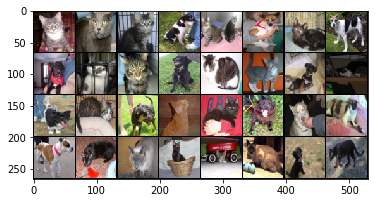

In [12]:
## test the model with 1 batch (not trained on our data yet)
# to show that the model cannot predict yet 
model = get_resnet_model()
for images, labels in trainloader:
    #print("batch size:", images.shape)
    out = model(images)
    #print("batch size:", out.shape)
    print('Model output: ', torch.max(out, dim=1)[1])
    print('Ground Truth: ',labels)
    imshow(torchvision.utils.make_grid(images))
    break

In [13]:
#Training the Model
learning_rate = 0.001 # one of the hyperparameters 
# 20000 / 32 ~ 625
# 5 * 625 = ~3125
num_epochs = 5 # one of the hyperparameters 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_resnet_model()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
device

device(type='cuda', index=0)

In [15]:
## a fucntion to compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [16]:
import tqdm # to ccheck progress within one epoch 
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in tqdm.tqdm(enumerate(trainloader)):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()

        ## update model params: W = W - alpha * grad
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss/i, train_acc/i))    
         

625it [01:38,  6.33it/s]
1it [00:00,  6.60it/s]

Epoch: 0 | Loss: 0.3572 | Train Accuracy: 84.62


625it [01:37,  6.43it/s]
1it [00:00,  6.43it/s]

Epoch: 1 | Loss: 0.2338 | Train Accuracy: 90.38


625it [01:37,  6.44it/s]
1it [00:00,  6.09it/s]

Epoch: 2 | Loss: 0.2054 | Train Accuracy: 91.66


625it [01:37,  6.43it/s]
1it [00:00,  6.23it/s]

Epoch: 3 | Loss: 0.1907 | Train Accuracy: 92.66


625it [01:37,  6.42it/s]

Epoch: 4 | Loss: 0.1377 | Train Accuracy: 94.80


In [17]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 87.38


In [18]:

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
    print('Test Accuracy: %.2f'%( test_acc/i))


Test Accuracy: 92.15


In [18]:
# save your model 
PATH = 'mymodel.pt' 
torch.save(model, PATH)


C:\ProgramData\Anaconda3\envs\cats_n_dogs\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\cats_n_dogs\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\cats_n_dogs\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\envs\cats_n_dogs\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loadin

In [32]:
# load your model 
PATH = 'mymodel.pt' 
the_model = torch.load(PATH)


In [28]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 87.38


In [20]:
## test the model with 1 batch ( trained on our data yet)
# to show that the model cannot predict yet 
the_model = get_resnet_model()
for images, labels in testloader:
    #print("batch size:", images.shape)
    out = the_model(images)
    print("batch size:", out.shape)
    print('Model output: ', torch.max(out, dim=1)[1])
    print('Ground Truth: ',labels)
    imshow(torchvision.utils.make_grid(images))
    break

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _thnn_conv2d_forward

Model output:  tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
Ground Truth:  tensor([0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 1], device='cuda:0')


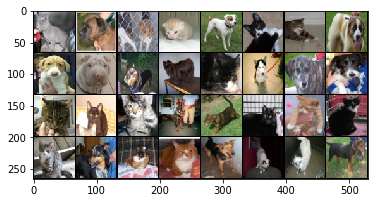

In [32]:
## test the model with 1 batch ( trained on our data yet)
# to show that the model cannot predict yet 
#model = get_resnet_model()
for i, (images, labels) in enumerate(testloader, 0):
    imshow(torchvision.utils.make_grid(images))
    images = images.to(device)
    labels = labels.to(device)
    out = model(images)
    #print("batch size:", out.shape)
    print('Model output: ', torch.max(out, dim=1)[1])
    print('Ground Truth: ',labels)
    break;